In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('retina')

# Notebook 16: Expectation Maximization in practice


## Learning Goal 
The goal of this notebook is to gain intuition for Expectation Maximization using a simple example involving coin tosses.

## Overview

In Section XIV, we introduce Expectation-Maximization (EM) as a practical way to perform maximum likelihood estimation (MLE) even when some of the data is hidden (i.e in the presence of latent or hidden variables). To better understand EM, in this short notebook we'll explore a very simple coin-tossing example adapted from [Do and Batzoglou, Nat. Biotechnol. (2008)](https://www.nature.com/articles/nbt1406). 

Suppose that we are given two coins A and B with unkown bias $\theta_A$ and $\theta_B$, respectively. Our goal is to estimate the bias vector $\boldsymbol{\theta}= (\theta_A, \theta_B)$ from the outcomes of the following experiment: 

<blockquote> 
First choose one coin at random. Then toss the selected coin 10 times independently and record the number of heads observed. Repeat this procedure 5 times.
</blockquote>

Formally, let $z_i\in\{A,B\}$ be the coin selected in experiment $i$ and $x_i\in\{0,1,\cdots 10\}$ be the number heads recorded by tossing $z_i$ 10 times. Since we conduct $n=5$ such experiments, we can summarize the outcomes of these 50 tosses by two vectors: $\boldsymbol{x}=(x_1,x_2\cdots, x_5)$ and $\boldsymbol{z}=(z_1,z_2,\cdots, z_5)$.




### Exercise 1: What if we know everything?

 * Consider first the case where we have complete knowledge of the experiment, namely, both $\boldsymbol{x}$ and $\boldsymbol{z}$ are known. How would you intuitively estimate the biases of the two coins  $\boldsymbol{\theta}= (\theta_A, \theta_B)$ ?
    - For each experiment, x$_i$/10 gives the fraction of the tosses that were heads for given coin z$_i$. What I would do, then, is choose the experiemnts where z$_i$ = A and calculate the fraction of those events where heads came up. The same for z$_i$ = B. 

 * What's the likelihood of observing the complete outcomes of these experiments? In other words, what is $P(\boldsymbol{x},\boldsymbol{z}| n,\boldsymbol{\theta} )$? You may assume this is a Bernoulli trial. Namely, every time coin A(B) is tossed, we have, with probability $\theta_A$($\theta_B$), that the outcome is heads.
 

$$P(\mathbf{x}, \mathbf{z} | n, \theta) = \frac{1}{2} \binom{10}{x} \theta_z^x (1-\theta_z)^{10-x}$$

* What's the Maximum Likelihood Estimator (MLE)? Is this consistent with your intuition? 
    - Write the log of the likelihood function: 
    $$ \log L = \log(1/2) + \log\left[\binom{10}{x}\right] + x\log{\theta_z} + (10-x)\log(1-\theta_z).$$
    - Take the derivative with respect to $\theta_z$ and set it equal to 0: 
    $$ \frac{x}{\theta_z} - \frac{10-x}{1-\theta_z}  = 0.$$
    - Solving this gives $$\theta_z = \frac{x}{10}.$$ This agrees with my intuition. 

## Comparing MLE and EM

To test your answer, let's do some numerics! We will compare the MLE estimates of biases with an Expectation Maximization procedure where we do not know ${\bf z}$. The following code computes our best guess for the biases using MLE -- assuming we know the identity of the coin used -- and compares it estimates arrived at using an EM procedure where we have no knowledge about which coin was being tossed (though we know the same coin was tossed 10 times).

In [2]:
import numpy as np
from scipy.special import comb
import math

#np.random.seed(8675309)

def compute_likelihood(obs, n, pheads): # No surprise, it's Binomial!!!

    likelihood = comb(n, obs, exact=True)*(pheads**obs)*(1.0-pheads)**(n-obs)

    return likelihood

# generate experiments
num_coin_toss = 10 # each experiment contains num_coin_toss tosses
num_exp = 5  # we perform 5 such experiments
theta_A_true = 0.8 
theta_B_true = 0.4
coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
head_counts = np.zeros(num_exp)

# MLE 
MLE_A = 0.0
MLE_B = 0.0

# generate the outcomes of experiment
for i in np.arange(num_exp):
    
    if np.random.randint(2) == 0: # coin A is selected
        head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
        MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 
    
    else: # coin B is selected 
        head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
        coin_choice[i] = 1  # record the selection of coin B during experiment i 
        MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 
    
tail_counts = num_coin_toss - head_counts


# MLE is merely the proportion of heads for each coin toss
MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)



# initialize the pA(heads) and pB(heads), namely, coin biases
pA_heads = np.zeros(100); 
pB_heads = np.zeros(100); 

pA_heads[0] = 0.60 # initial guess
pB_heads[0] = 0.50 # initial guess

# E-M begins!
epsilon = 0.001   # error threshold
j = 0 # iteration counter
improvement = float('inf')

while (improvement > epsilon):
    
    expectation_A = np.zeros((num_exp,2), dtype=float) 
    expectation_B = np.zeros((num_exp,2), dtype=float)
    
    for i in np.arange(min(len(head_counts),len(tail_counts))):
        
        eH = head_counts[i]
        eT = tail_counts[i]
        
        # E step:
        lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
        lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])
        
        weightA = lA / (lA + lB)
        weightB = lB / (lA + lB)
              
        expectation_A[i] = weightA*np.array([eH, eT])
        expectation_B[i] = weightB*np.array([eH, eT])

  
    # M step
    theta_A = np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
    theta_B = np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B) 

    print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))
    
    pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
    pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

    improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
    j = j+1

# END of E-M, print the outcome

print('E-M converges at iteration %d' %j)
print('RESULT:')
print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))
print('\nE-M error: \ntheta_A: %.0f%%\ntheta_B %.0f%%' %(100*(theta_A - theta_A_true)/theta_A_true, \
                                                         100*(theta_B - theta_B_true)/theta_B_true))
print('\nMLE error: \nMLE_A: %.0f%%\nMLE_B %.0f%%' %(100*(MLE_A - theta_A_true)/theta_A_true, \
                                                     100*(MLE_B - theta_B_true)/theta_B_true))

At iteration 0, theta_A = 0.746319,  theta_B = 0.619471
At iteration 1, theta_A = 0.777413,  theta_B = 0.613351
At iteration 2, theta_A = 0.794627,  theta_B = 0.597108
At iteration 3, theta_A = 0.804390,  theta_B = 0.583955
At iteration 4, theta_A = 0.809132,  theta_B = 0.575557
At iteration 5, theta_A = 0.811200,  theta_B = 0.570746
At iteration 6, theta_A = 0.812062,  theta_B = 0.568125
At iteration 7, theta_A = 0.812420,  theta_B = 0.566730
At iteration 8, theta_A = 0.812572,  theta_B = 0.565997
E-M converges at iteration 9
RESULT:
E-M: theta_A = 0.812572,  theta_B = 0.565997
MLE with complete data: theta_A = 0.725000,  theta_B = 0.600000

E-M error: 
theta_A: 2%
theta_B 41%

MLE error: 
MLE_A: -9%
MLE_B 50%


### Exercise 2

 * How fast does EM converge? Is the converged result close to what you'd get from MLE? 
 
    - EM converges between 5 and 10 steps, usually. Often the EM result is really close to MLE but every now and then the result is appreciably different.

 * Following Exercise 1, what's the objective function we're optimizing in the E-step? Does this function have a *unique global maximum*? 
    - We're optimizing the expectation of the log likelihood of $\theta$ using the current estimates. 
    - Because this is a numerical solution, I belive there is no guarentee of a unique global maximum since there is no functional form. 

 * Compare both the results of MLE and EM to the actual bias (i.e. *theta_A_true*  and *theta_B_true* in the snippet above), comment on their performance.
    - While EM and MLE often give the same results, they are not often exactly right. Errors betwen 0 and 25% are typical but can get as high as 50%. 

## Final remarks: a few practical tricks

From Exercise 2 and Section XIV, we know that the E-M algorithm often approximates the MLE even in the presence of latent (hidden variables). Like with most optimization methods for nonconcave functions, E-M only guarantees convergence to a local maximum of the objective function. For this reason, its performance can be boosted by running the EM procedure starting with multiple initial parameters. 

### Exercise 3

* Now instead of having a fixed initial guess of coin biases (i.e. *pA_heads[0]* and *pB_heads[0]* in the snippet), draw these values uniformly at random from $[0,1]$ and run the E-M algorithm. Repeat this twenty times and report what you observed. What's the best initial guess that gives the closest estimate to the true parameters?

In [3]:
pA_heads0_arr = []
pB_heads0_arr = []

EM_thetaAerr_arr = []
EM_thetaBerr_arr = []

MLE_thetaAerr_arr = []
MLE_thetaBerr_arr = []

counter = 0 
while counter < 20:
    # generate experiments
    num_coin_toss = 10 # each experiment contains num_coin_toss tosses
    num_exp = 5  # we perform 5 such experiments
    theta_A_true = 0.8 
    theta_B_true = 0.4
    coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
    head_counts = np.zeros(num_exp)

    # MLE 
    MLE_A = 0.0
    MLE_B = 0.0

    # generate the outcomes of experiment
    for i in np.arange(num_exp):

        if np.random.randint(2) == 0: # coin A is selected
            head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
            MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 

        else: # coin B is selected 
            head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
            coin_choice[i] = 1  # record the selection of coin B during experiment i 
            MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 
            
    if ((np.count_nonzero(coin_choice) == 0) or (np.count_nonzero(coin_choice) == 5)):
        continue

    tail_counts = num_coin_toss - head_counts


    # MLE is merely the proportion of heads for each coin toss
    MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
    MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)



    # initialize the pA(heads) and pB(heads), namely, coin biases
    pA_heads = np.zeros(100); 
    pB_heads = np.zeros(100); 

    pA_heads[0] = np.random.rand() # initial guess
    pB_heads[0] = np.random.rand() # initial guess

    # E-M begins!
    epsilon = 0.001   # error threshold
    j = 0 # iteration counter
    improvement = float('inf')

    while (improvement > epsilon):

        expectation_A = np.zeros((num_exp,2), dtype=float) 
        expectation_B = np.zeros((num_exp,2), dtype=float)

        for i in np.arange(min(len(head_counts),len(tail_counts))):

            eH = head_counts[i]
            eT = tail_counts[i]

            # E step:
            lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
            lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])

            weightA = lA / (lA + lB)
            weightB = lB / (lA + lB)

            expectation_A[i] = weightA*np.array([eH, eT])
            expectation_B[i] = weightB*np.array([eH, eT])


        # M step
        theta_A = np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
        theta_B = np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B) 

        #print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))

        pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
        pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

        improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
        j = j+1

    # END of E-M, print the outcome
    '''
    print('E-M converges at iteration %d' %j)
    print('RESULT:')
    print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
    print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))
    print('\nE-M error: \ntheta_A: %.0f%%\ntheta_B %.0f%%' %(100*(theta_A - theta_A_true)/theta_A_true, \
                                                             100*(theta_B - theta_B_true)/theta_B_true))
    print('\nMLE error: \nMLE_A: %.0f%%\nMLE_B %.0f%%' %(100*(MLE_A - theta_A_true)/theta_A_true, \
                                                         100*(MLE_B - theta_B_true)/theta_B_true))
    '''
    
    pA_heads0_arr.append(pA_heads[0])
    pB_heads0_arr.append(pB_heads[0])
    
    EM_thetaAerr_arr.append((theta_A - theta_A_true)/theta_A_true)
    EM_thetaBerr_arr.append((theta_B - theta_B_true)/theta_B_true)

    MLE_thetaAerr_arr.append((MLE_A - theta_A_true)/theta_A_true)
    MLE_thetaBerr_arr.append((MLE_B - theta_B_true)/theta_B_true)
    
    counter += 1

In [4]:
import matplotlib.pyplot as plt

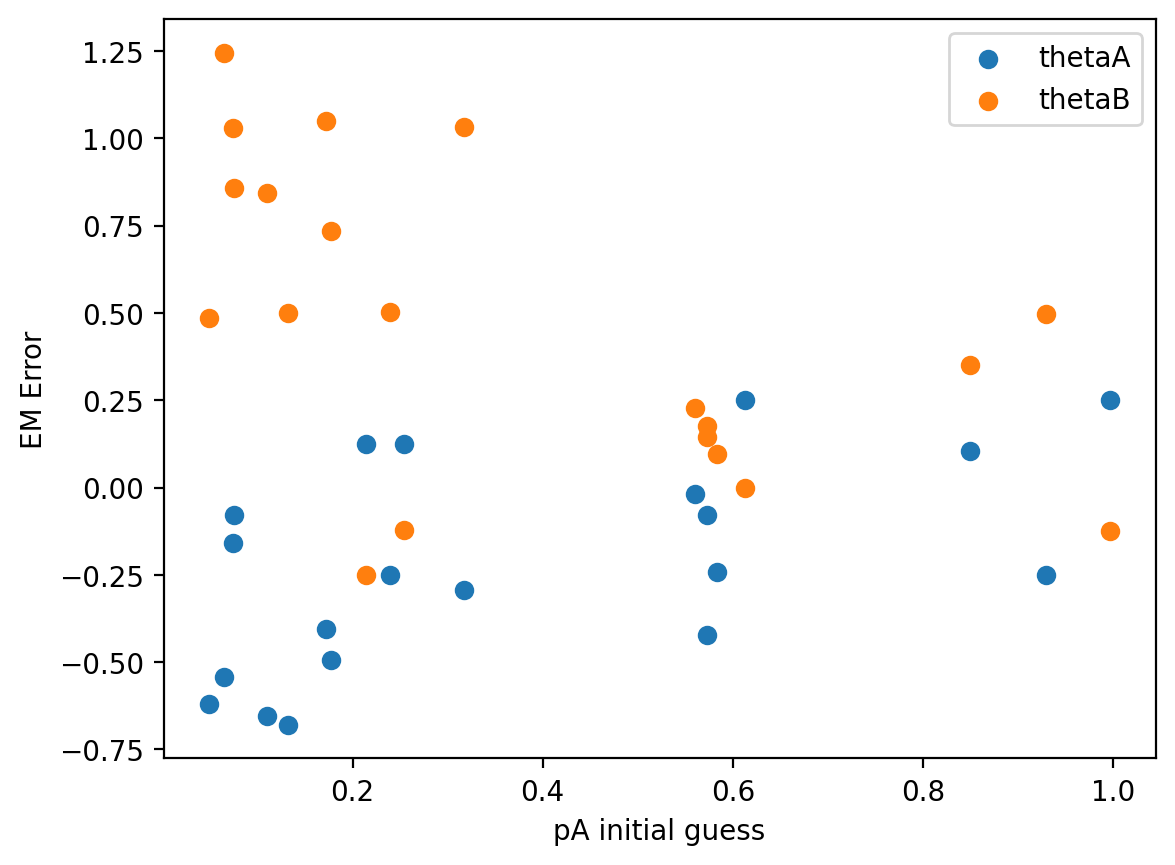

In [5]:
plt.scatter(pA_heads0_arr, EM_thetaAerr_arr, label='thetaA')
plt.scatter(pA_heads0_arr, EM_thetaBerr_arr, label='thetaB')
plt.xlabel('pA initial guess')
plt.ylabel('EM Error')
plt.legend()
plt.show()

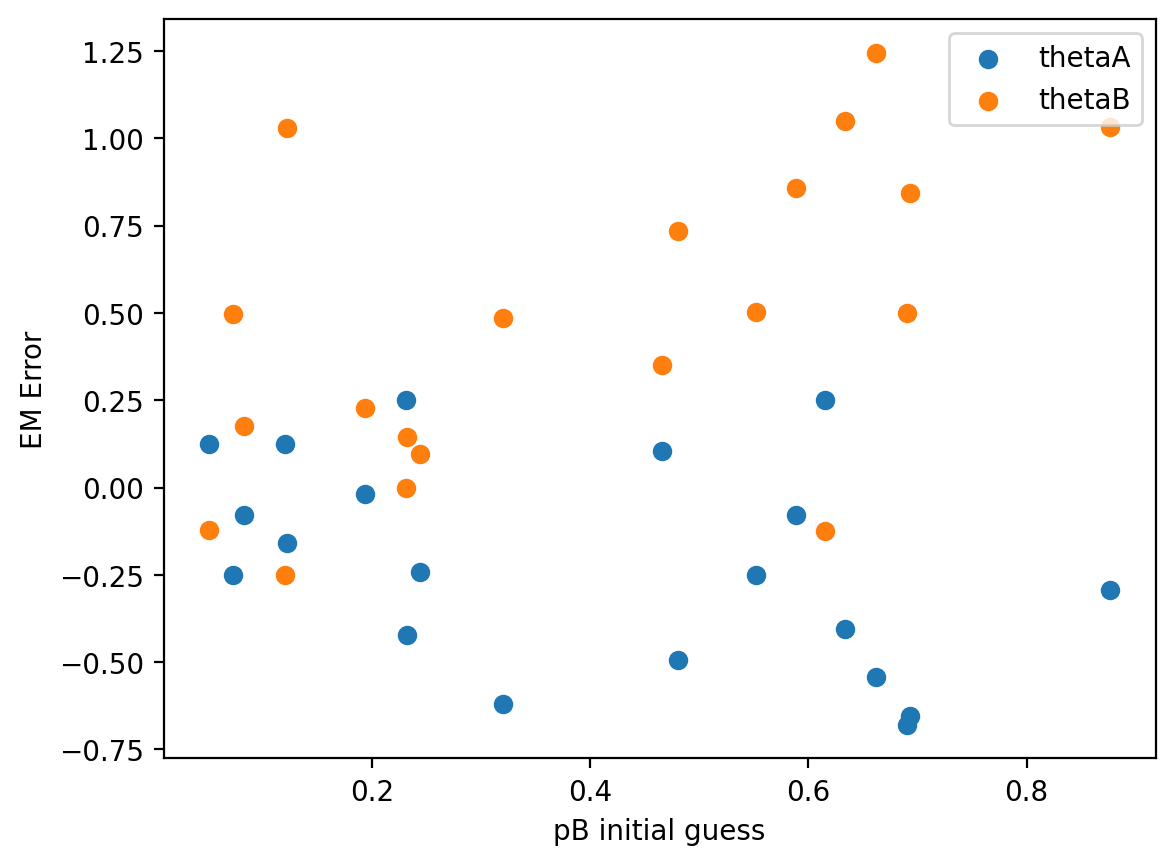

In [6]:
plt.scatter(pB_heads0_arr, EM_thetaAerr_arr, label='thetaA')
plt.scatter(pB_heads0_arr, EM_thetaBerr_arr, label='thetaB')
plt.xlabel('pB initial guess')
plt.ylabel('EM Error')
plt.legend()
plt.show()

- The best initial guess is pA = 1 and pB = 0.

* As we discussed in Section X (LinReg), **Maximum a posteriori (MAP)** estimation differs from MLE in that it employs an augmented objective function which incorporates a prior distribution over the quantities we want to estimate, and the prior distribution can be think of as a regularizer for the objective fuction used in MLE. Here we will explore how to extend E-M to MAP estimation. 

  (1) First derive the MAP estimate for the one-coin-flipping example, namely,
  $$
  \hat{{\theta}}_{MAP}(\boldsymbol{x}) = \arg\max_{\theta\in[0,1]} \log P(\boldsymbol{x}|n,{\theta} ) + \log P({\theta}),
  $$
  where 
  $$P(\boldsymbol{x}|n,{\theta}) = \prod_{i=1}^{10} \text{Binomial} (x_i|n,\theta)$$
  
  $$P({\theta})=\mathcal{N}(\theta|\mu, \sigma)$$
  

$$\text{Binomial} (x_i|n,\theta) \propto \theta^{x_i} \left(1-\theta\right)^{n - x_i} $$

$$\text{Binomial} (x_i|n,\theta) \propto x_i \log\theta + (n-x_i) \log(1-\theta)$$

$$\log P(\mathbf{x} | n, \theta) \propto \sum_i \left[ x_i \log\theta + (n-x_i) \log(1-\theta) \right]$$

$$\hat{{\theta}}_{MAP}(\boldsymbol{x}) = \arg\max_{\theta\in[0,1]} \sum_i \left[ x_i \log\theta + (n-x_i) \log(1-\theta) \right] + \log\mathcal{N}(\theta|\mu, \sigma)$$

Take the derivative w.r.t. $\theta$ and set equal to 0:
$$\sum_i \left[ \frac{x_i}{\theta} - \frac{n-x_i}{1-\theta} \right] + \frac{d}{d\theta} \log\mathcal{N}(\theta|\mu, \sigma) = 0$$

$$\frac{x}{\theta} - \frac{n-x}{1-\theta} + \log \mathcal{N} \left[\frac{-1}{\theta} - \frac{\log \theta - \mu}{\theta \sigma^2} \right] = 0 $$

I'm not sure what to do at this stage.

  (2) Based on (1), now modify the E-M snippet above to incorporate this prior distribution into the **M-step**. Comment on the performance. For the prior choice, try $P(\boldsymbol{\theta})=\mathcal{N}(\theta_A|0.83, 1)\mathcal{N}(\theta_B|0.37, 1)$.

In [17]:
np.random.seed(8675309)

# generate experiments
num_coin_toss = 10 # each experiment contains num_coin_toss tosses
num_exp = 5  # we perform 5 such experiments
theta_A_true = 0.8 
theta_B_true = 0.4
coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
head_counts = np.zeros(num_exp)

# MLE 
MLE_A = 0.0
MLE_B = 0.0

# generate the outcomes of experiment
for i in np.arange(num_exp):
    
    if np.random.randint(2) == 0: # coin A is selected
        head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
        MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 
    
    else: # coin B is selected 
        head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
        coin_choice[i] = 1  # record the selection of coin B during experiment i 
        MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 
    
tail_counts = num_coin_toss - head_counts


# MLE is merely the proportion of heads for each coin toss
MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)


# initialize the pA(heads) and pB(heads), namely, coin biases
pA_heads = np.zeros(100); 
pB_heads = np.zeros(100); 

pA_heads[0] = 0.60 # initial guess
pB_heads[0] = 0.50 # initial guess

# E-M begins!
epsilon = 0.001   # error threshold
j = 0 # iteration counter
improvement = float('inf')

while (improvement > epsilon):
    
    expectation_A = np.zeros((num_exp,2), dtype=float) 
    expectation_B = np.zeros((num_exp,2), dtype=float)
    
    for i in np.arange(min(len(head_counts),len(tail_counts))):
        
        eH = head_counts[i]
        eT = tail_counts[i]
        
        # E step:
        lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
        lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])
        
        weightA = lA / (lA + lB)
        weightB = lB / (lA + lB)
              
        expectation_A[i] = weightA*np.array([eH, eT])
        expectation_B[i] = weightB*np.array([eH, eT])

  
    # M step
    theta_A = np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
    theta_B = np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B) 

    print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))
    
    pA_heads[j+1] = ( sum(expectation_A)[0] / sum(sum(expectation_A)) + np.random.normal(0.83, 1)*np.random.normal(0.83, 1) )/2 
    pB_heads[j+1] = ( sum(expectation_B)[0] / sum(sum(expectation_B)) + np.random.normal(0.37, 1)*np.random.normal(0.37, 1) )/2  

    improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
    j = j+1

# END of E-M, print the outcome

print('E-M converges at iteration %d' %j)
print('RESULT:')
print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))
print('\nE-M error: \ntheta_A: %.0f%%\ntheta_B %.0f%%' %(100*(theta_A - theta_A_true)/theta_A_true, \
                                                         100*(theta_B - theta_B_true)/theta_B_true))
print('\nMLE error: \nMLE_A: %.0f%%\nMLE_B %.0f%%' %(100*(MLE_A - theta_A_true)/theta_A_true, \
                                                     100*(MLE_B - theta_B_true)/theta_B_true))

At iteration 0, theta_A = 0.634557,  theta_B = 0.423942
At iteration 1, theta_A = 0.384275,  theta_B = 0.727629
At iteration 2, theta_A = 0.506565,  theta_B = 1.000375
At iteration 3, theta_A = 0.513447,  theta_B = 0.514409
At iteration 4, theta_A = 0.999763,  theta_B = 0.399990
At iteration 5, theta_A = 1.042986,  theta_B = 0.402408
At iteration 6, theta_A = 0.254954,  theta_B = 0.519856
At iteration 7, theta_A = 0.519994,  theta_B = 0.149492
At iteration 8, theta_A = 0.520000,  theta_B = 0.241395
At iteration 9, theta_A = 0.552480,  theta_B = 0.370979
At iteration 10, theta_A = 0.520000,  theta_B = 0.268121
At iteration 11, theta_A = 0.401410,  theta_B = 1.027367
At iteration 12, theta_A = 0.514824,  theta_B = 0.250778
At iteration 13, theta_A = 0.527652,  theta_B = 0.327095
At iteration 14, theta_A = 0.722338,  theta_B = 0.383963
At iteration 15, theta_A = 0.511473,  theta_B = 1.333698
At iteration 16, theta_A = 0.390503,  theta_B = 0.699011
At iteration 17, theta_A = 0.912060,  the

IndexError: index 100 is out of bounds for axis 0 with size 100